# Ptychography Toy Model with Phase Observation (Bilinear Reconstruction)

This example presents a **simplified reconstruction problem** designed to isolate and study the *bilinear* aspect of ptychography.

### 1. Problem Definition

Ptychography is a scanning diffraction imaging technique that measures
diffraction patterns while a localized probe is translated across an extended object.

In the standard (intensity-only) setting, each diffraction frame corresponds to the **magnitude** of the Fourier transform:

$$
A_i(k) = |\mathcal{F}\{ P(r) \cdot O(r - r_i) \}| + \text{noise},
$$

where $P(r)$ is the probe, $O(r)$ is the object, $r_i$ are the scan positions, and $\mathcal{F}$ denotes the 2D Fourier transform.


In this **toy model**, we instead assume that the **complex-valued diffraction field**

$$
Z_i(k) = \mathcal{F}\{ P(r) \cdot O(r - r_i) \} + \text{noise}
$$

is directly observed (i.e., the phase is known).  
This setting removes the nonlinear modulus operation and thus eliminates the phase retrieval difficulty.  
The resulting model is *bilinear* in $P$ and $O$.


The discretized form is given by:

$$
\mathbf{Z}_i = \mathrm{F}\{ \mathbf{P} \odot \mathrm{S}^{(i)} \mathbf{O} \} + \text{noise},
$$

where  

- $\mathbf{O} \in \mathbb{C}^N$: discretized object,  
- $\mathbf{P} \in \mathbb{C}^M$: discretized probe,  
- $\mathrm{S}^{(i)} \in \{0,1\}^{M \times N}$: patch-extraction operator at position $i$,  
- $\mathrm{F}$: 2D discrete Fourier transform.

---

Our goal in this example is to jointly estimate the unknown object $\mathbf{O}$
and probe $\mathbf{P}$ from the observed complex diffraction frames
$\mathbf{Z}_i \ (i = 1,2,\ldots,J)$, assuming a Gaussian observation model:

$$
\mathbf{Z}_i \sim \mathcal{CN}\big( \mathrm{F}\{ \mathbf{P} \odot \mathrm{S}^{(i)} \mathbf{O} \}, \sigma^2 \mathbf{I} \big).
$$

**Unlike `ptychography_demo.ipynb`, where the probe is known and only the amplitude of each diffraction pattern is observed,  
this example assumes that both the probe and object are unknown but the full complex diffraction field (including phase) is available.**  
This simplified setting allows us to focus solely on the *bilinear* aspect of blind ptychography.


In [46]:
#imports
import numpy as np
from gpie.imaging.ptychography.simulator.probe import generate_probe
from gpie.imaging.ptychography.simulator.scan import generate_fermat_spiral_positions

# load sample image from sk-image library
import os
import sys
EXAMPLES_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, EXAMPLES_DIR)

from io_utils import load_sample_image

### 2. Synthetic data

In this demonstration, we manually construct the synthetic object and probe using utility functions from `gpie.imaging.ptychography.simulator` and `gpie.imaging.ptychography.utils`.

In [47]:
# Generate synthetic object and probe

# --- Object (amplitude × phase) ---
obj_shape = (256, 256)
amp = load_sample_image("camera", shape=obj_shape)
phase = load_sample_image("coins", shape=obj_shape)
obj_gt = amp * np.exp(1j * phase) # ground truth

# --- Probe ---
pixel_size = 0.1  # µm per pixel
prb_shape = (128, 128)
prb_gt = generate_probe(
    shape=prb_shape,
    pixel_size=pixel_size,
    space = "fourier",
    aperture_radius=0.3,
    smooth_edge_sigma=0.1,
) # ground truth

In [48]:
from gpie.imaging.ptychography.utils.geometry import realspace_to_pixel_coords, slices_from_positions

# generate scan positions
num_scans = 50
scan_gen = generate_fermat_spiral_positions(step_um=0.5) # Generator objecct of python
positions_real = [next(scan_gen) for _ in range(num_scans)] # scan positions in real-coordinate
positions_pixel = realspace_to_pixel_coords(positions_real = positions_real, # convert real-space coordinate into pixel indices
                                    pixel_size_um = pixel_size,
                                    obj_shape = obj_shape)
indices = slices_from_positions(pixel_positions = positions_pixel,
                                probe_shape = prb_shape,
                                obj_shape = obj_shape) # get a list of slice objects (this is input to initialize the gpie.graph object)

#### Visualization

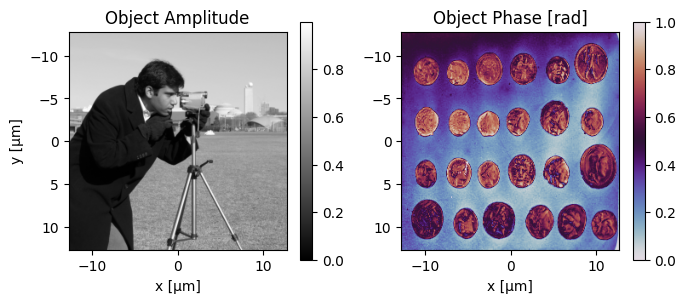

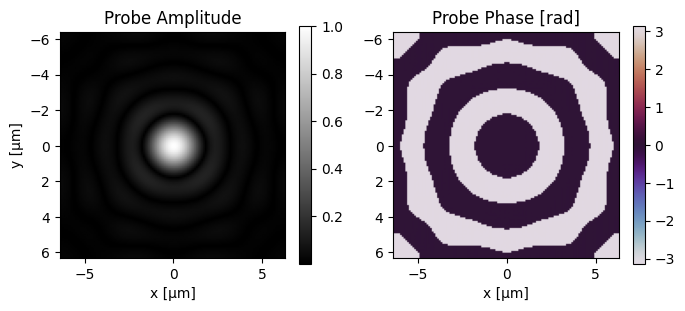

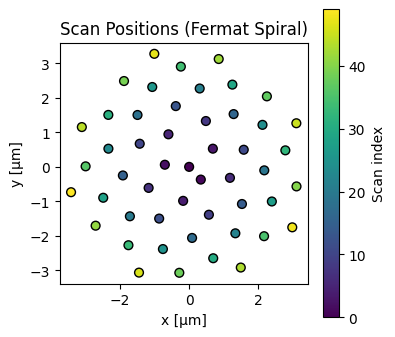

In [49]:
import matplotlib.pyplot as plt

# Object coordinates (real-space)
ny, nx = obj_shape
x_obj = (np.arange(nx) - nx // 2) * pixel_size
y_obj = (np.arange(ny) - ny // 2) * pixel_size

# Probe coordinates
ny_p, nx_p = prb_shape
x_prb = (np.arange(nx_p) - nx_p // 2) * pixel_size
y_prb = (np.arange(ny_p) - ny_p // 2) * pixel_size

# === Visualization: Object ===
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
im0 = axes[0].imshow(np.abs(obj_gt), cmap = "gray", extent=[x_obj[0], x_obj[-1], y_obj[-1], y_obj[0]])
axes[0].set_title("Object Amplitude")
axes[0].set_xlabel("x [µm]")
axes[0].set_ylabel("y [µm]")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(np.angle(obj_gt), cmap="twilight", extent=[x_obj[0], x_obj[-1], y_obj[-1], y_obj[0]])
axes[1].set_title("Object Phase [rad]")
axes[1].set_xlabel("x [µm]")
plt.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

# === Visualization: Probe ===
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
im0 = axes[0].imshow(np.abs(prb_gt), cmap = "gray", extent=[x_prb[0], x_prb[-1], y_prb[-1], y_prb[0]])
axes[0].set_title("Probe Amplitude")
axes[0].set_xlabel("x [µm]")
axes[0].set_ylabel("y [µm]")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(np.angle(prb_gt), cmap="twilight", extent=[x_prb[0], x_prb[-1], y_prb[-1], y_prb[0]])
axes[1].set_title("Probe Phase [rad]")
axes[1].set_xlabel("x [µm]")
plt.colorbar(im1, ax=axes[1])
plt.tight_layout()
plt.show()

# === Visualization: Scan positions ===
positions_real = np.array(positions_real)
plt.figure(figsize=(4, 4))
plt.scatter(positions_real[:, 0], positions_real[:, 1], c=np.arange(len(positions_real)),
            cmap="viridis", s=40, edgecolor="k")
plt.xlabel("x [µm]")
plt.ylabel("y [µm]")
plt.title("Scan Positions (Fermat Spiral)")
plt.gca().set_aspect("equal")
plt.colorbar(label="Scan index")
plt.show()


### 3. Define a model in gPIE

The following code defines a **blind ptychography model** where both the object and probe are unknown, and the observed data contain the full complex-valued diffraction field (including phase):

In [50]:
from gpie import model, fft2, GaussianPrior, GaussianMeasurement, AmplitudeMeasurement
from typing import Tuple, List

@model
def blind_ptychography_with_phase_observation(
    obj_shape,
    prb_shape,                    
    indices,
    noise: float,
):
    obj = ~GaussianPrior(event_shape=obj_shape, label="object")
    prb = ~GaussianPrior(event_shape=prb_shape, label="probe")
    patches = obj.extract_patches(indices)
    exit_waves = prb * patches  
    GaussianMeasurement(var=noise) << fft2(exit_waves)
    return

### 4. Simulate observation

In [51]:
# set noise variance
noise = 1e-3

# initialize a gpie.graph object
g = blind_ptychography_with_phase_observation(
    obj_shape = obj_shape, # (256, 256)
    prb_shape = prb_shape, # (128, 128)                
    indices = indices, # fermat spiral
    noise = noise
)

# generate the observation dataset
g.set_init_rng(np.random.default_rng(seed=1))
g.get_wave("object").set_sample(obj_gt)
g.get_wave("probe").set_sample(prb_gt)
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)

- `get_wave("object")` retrieves the latent node labeled `"object"`  
- `set_sample(...)` injects the true complex image  
- `generate_sample(...)` simulates noisy observed data

### 5. Run Inference

In [52]:
n_iter = 200

g.run(n_iter=n_iter)

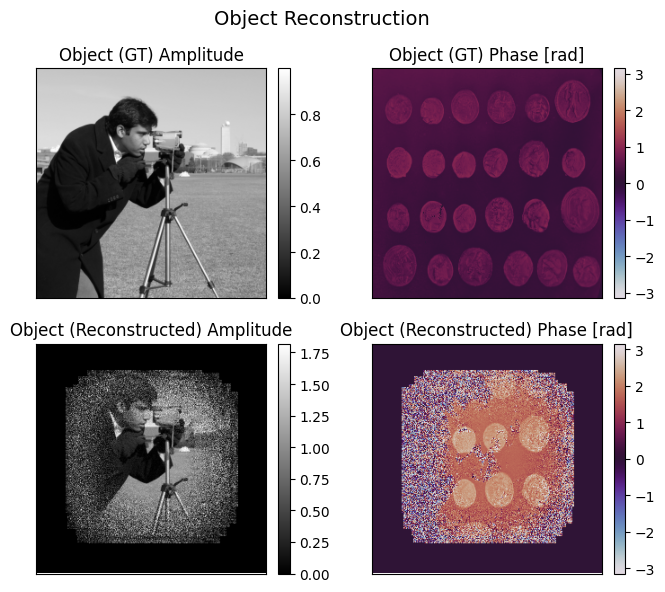

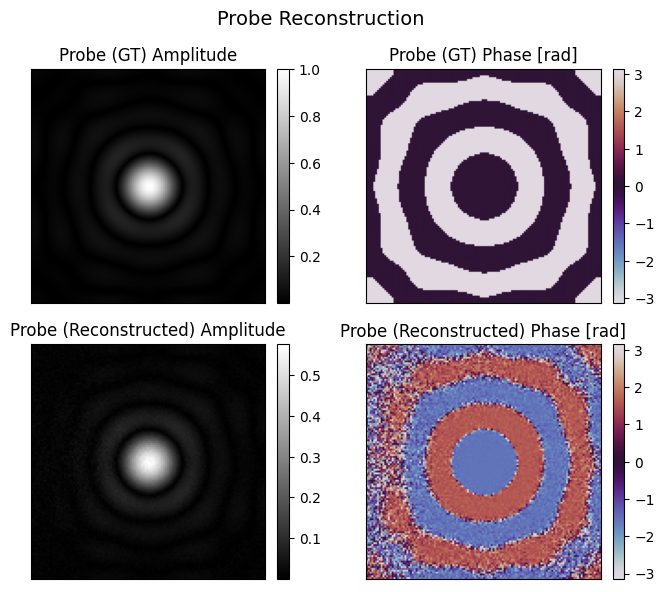

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# === Retrieve reconstructed estimates ===
obj_est = g.get_wave("object").compute_belief().data[0]
prb_est = g.get_wave("probe").compute_belief().data[0]

# === Helper function for visualization ===
def show_complex_field(axs, field_gt, field_est, title_prefix):
    """Visualize amplitude and phase for GT vs estimate."""
    im0 = axs[0, 0].imshow(np.abs(field_gt), cmap = "gray")
    axs[0, 0].set_title(f"{title_prefix} (GT) Amplitude")
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

    im1 = axs[0, 1].imshow(np.angle(field_gt), cmap="twilight", vmin=-np.pi, vmax=np.pi)
    axs[0, 1].set_title(f"{title_prefix} (GT) Phase [rad]")
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

    im2 = axs[1, 0].imshow(np.abs(field_est), cmap = "gray")
    axs[1, 0].set_title(f"{title_prefix} (Reconstructed) Amplitude")
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

    im3 = axs[1, 1].imshow(np.angle(field_est), cmap="twilight", vmin=-np.pi, vmax=np.pi)
    axs[1, 1].set_title(f"{title_prefix} (Reconstructed) Phase [rad]")
    plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

    for ax in axs.ravel():
        ax.set_xticks([])
        ax.set_yticks([])

# === Object visualization ===
fig, axs = plt.subplots(2, 2, figsize=(7,6))
show_complex_field(axs, obj_gt, obj_est, "Object")
fig.suptitle("Object Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()

# === Probe visualization ===
fig, axs = plt.subplots(2, 2, figsize=(7,6))
show_complex_field(axs, prb_gt, prb_est, "Probe")
fig.suptitle("Probe Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()


### 5. Visualizing Uncertainty Alongside Reconstruction Quality

Expectation Propagation (EP) provides not only the mean reconstruction but also  
a pixel-wise estimate of **posterior precision** (inverse variance), which indicates confidence.  

In the plots below, each reconstructed amplitude map is shown next to its corresponding precision field (log-scaled).  
Regions with low precision (dark) often coincide with visually noisy or uncertain areas in the reconstruction.

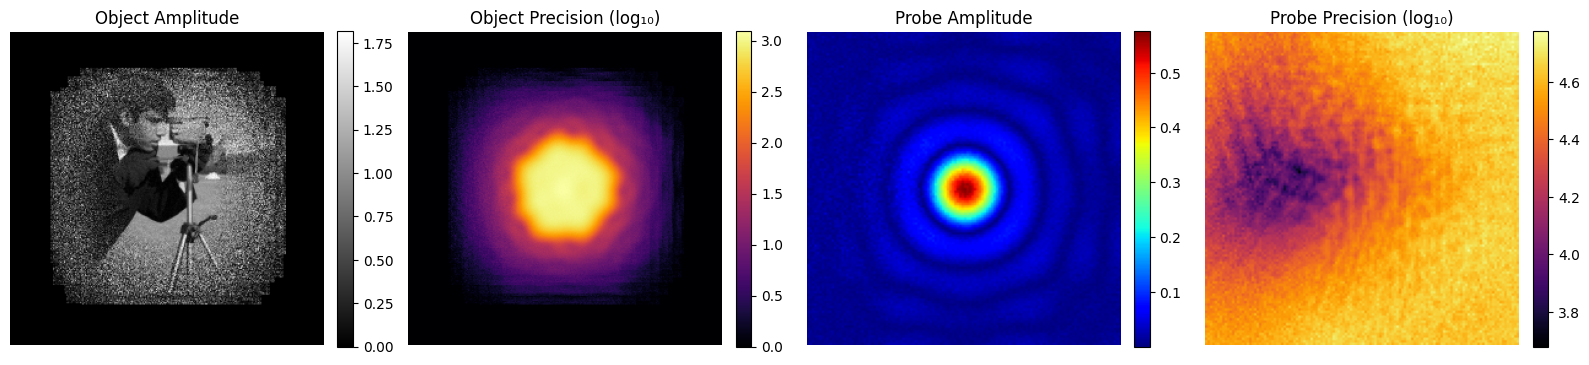

In [54]:
# === Retrieve reconstructed fields and precisions ===
obj_belief = g.get_wave("object").compute_belief()
prb_belief = g.get_wave("probe").compute_belief()

obj_est = obj_belief.data[0]
prb_est = prb_belief.data[0]
obj_prec = obj_belief.precision()[0]
prb_prec = prb_belief.precision()[0]

# === Combine all 4 images in a single row ===
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Object amplitude
im0 = axes[0].imshow(np.abs(obj_est), cmap="gray")
axes[0].set_title("Object Amplitude")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Object precision (log scale)
im1 = axes[1].imshow(np.log10(obj_prec + 1e-12), cmap="inferno")
axes[1].set_title("Object Precision (log₁₀)")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Probe amplitude
im2 = axes[2].imshow(np.abs(prb_est), cmap="jet")
axes[2].set_title("Probe Amplitude")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# Probe precision (log scale)
im3 = axes[3].imshow(np.log10(prb_prec + 1e-12), cmap="inferno")
axes[3].set_title("Probe Precision (log₁₀)")
axes[3].axis("off")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
